# Calculating EOF using monthly averaged SST data and plotting them
Read the sst data calculate standardized anomaly, detrend the data and then calculate EOF. Plots of EOF1 and 2 , PC 1 and 2 time series, and EOF expressed as correlation plots are drawn

In [1]:
#Import necessary Modules
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import glob
import xarray as xr
import datetime as dt
from eofs.standard import Eof
from scipy import signal
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

/root/anaconda3/envs/pyn_env/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
##############Read Sample File for coordinates#################
file_samp  ='/mnt/rc/NOAA-COBE-SST/sst.mon.mean.nc'
f = nc.Dataset(file_samp)
lat=f.variables['lat'][:]
lon=f.variables['lon'][:]
sst_atts=f.variables['sst']
sst=f.variables['sst'][:1560,:,:]           #Upto 2020 december
time=f.variables['time'][:1560]
print(time.shape)

(1560,)


In [3]:
#############Reshape sst into year, month, lat and lon#########################
sst_re=np.reshape(sst,(int(time.shape[0]/12),12,lat.shape[0],lon.shape[0]),order='C')
print(sst_re.shape)
print(sst_re.max())
print(sst_re.min())

(130, 12, 180, 360)
34.87
-1.7999996


In [4]:
################Subsetting Pacific region data###################
latbounds=[-40,40]
latselect=np.logical_and(lat>=latbounds[0],lat<=latbounds[1])
sst_sub=sst_re[:,:,latselect,:]
#print(sst_sub.shape)
print(sst_sub.min())
print(sst_sub.max())

-0.53249955
34.87


In [5]:
#################Calculate climatology and anomaly##############
sst_climato=np.mean(sst_sub,axis=0)
sst_anom=(sst_sub-sst_climato)/np.std(sst_sub,axis=0)
#print(sst_anom.shape)
print(sst_anom.min())
print(sst_anom.max())

-6.29028238384841
7.297334350545221


In [6]:
###############Detrend the sst#################################
sst_detrend=signal.detrend(sst_anom,axis=0)
print(sst_detrend.min())
print(sst_detrend.max())

###########Mask where missing value is present################
sst_mask=np.ma.masked_where(sst_detrend < -10000.0, sst_detrend)        #Masking out unrealistic values after detrend
print(sst_mask.min())

-32768.0
7.730731494656824
-5.916676355375456


In [7]:
##############Reshape data again to 3d#######################
sst_final=np.reshape(sst_mask,(sst_mask.shape[0]*sst_mask.shape[1],sst_mask.shape[2],sst_mask.shape[3]))
print(sst_final.shape)


(1560, 80, 360)


In [8]:
###############EOF Calculation#############################
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(lat[latselect]))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(sst_final, weights=wgts)

In [9]:
# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.
eof = solver.eofs(neofs=2)
pc = solver.pcs(npcs=2, pcscaling=1)
print(pc.shape)

eofascorel = solver.eofsAsCorrelation(neofs=2)
print(eofascorel.shape)


(1560, 2)
(2, 80, 360)


(80, 360)


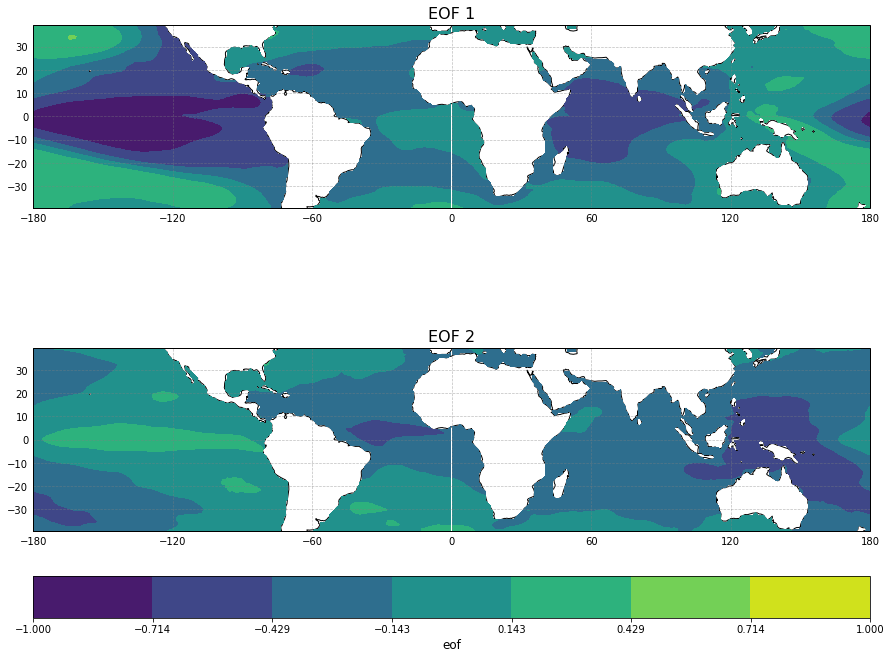

In [10]:
##############Plot the leading EOF expressed as correlation in the Pacific domain####################

lons,lats=np.meshgrid(lon,lat[latselect])
print(lats.shape)
clevs = np.linspace(-1.0,1.0, 8)

fig,(ax1,ax2)=plt.subplots(2,1,subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(15,12))

fill1 = ax1.contourf(lons, lats, eofascorel[0,:,:].squeeze(), clevs,transform=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND, facecolor='w', edgecolor='k')
ax1.set_title('EOF 1', fontsize=16)
gl=ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

fill2 = ax2.contourf(lons, lats, eofascorel[1,:,:].squeeze(), clevs,transform=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND, facecolor='w', edgecolor='k')
ax2.set_title('EOF 2', fontsize=16)
gl=ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

cb = plt.colorbar(fill2, orientation='horizontal')
cb.set_label('eof', fontsize=12)

plt.savefig('eof_as_correl.png')

In [11]:
#########Creating date strings for X axis#############
years=np.arange(1891,2021,5)
print(years)
x_lab=np.arange(0,pc.shape[0],60)
x=np.arange(0,pc.shape[0])

[1891 1896 1901 1906 1911 1916 1921 1926 1931 1936 1941 1946 1951 1956
 1961 1966 1971 1976 1981 1986 1991 1996 2001 2006 2011 2016]


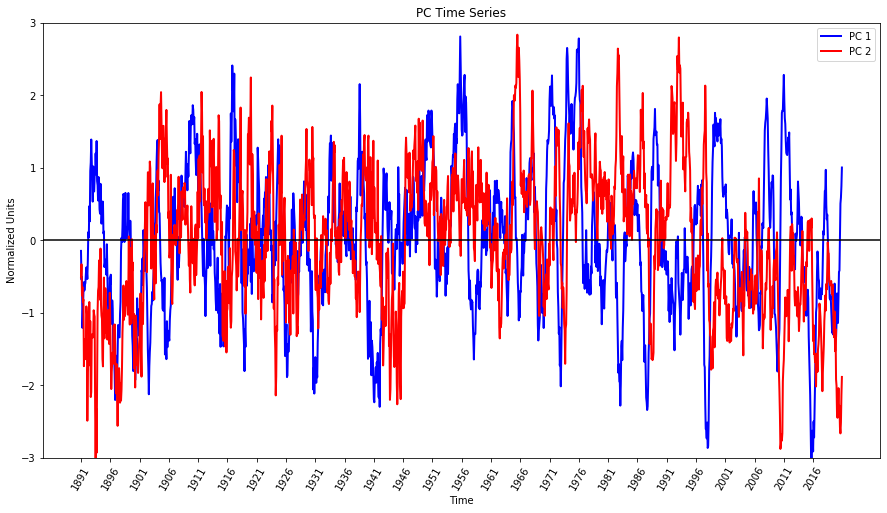

In [12]:
# Plot the leading PC time series.
plt.figure(figsize=(15,8))
plt.plot(x, pc[:,0], color='b', linewidth=2, label='PC 1')
plt.plot(x, pc[:,1], color='r', linewidth=2, label='PC 2')
plt.axhline(0, color='k')
plt.title('PC Time Series')
plt.xlabel('Time')
plt.xticks(x_lab,years,rotation=60)
plt.ylabel('Normalized Units')
plt.ylim(-3, 3)
lg=plt.legend()
plt.savefig('pc_time_sst.png')

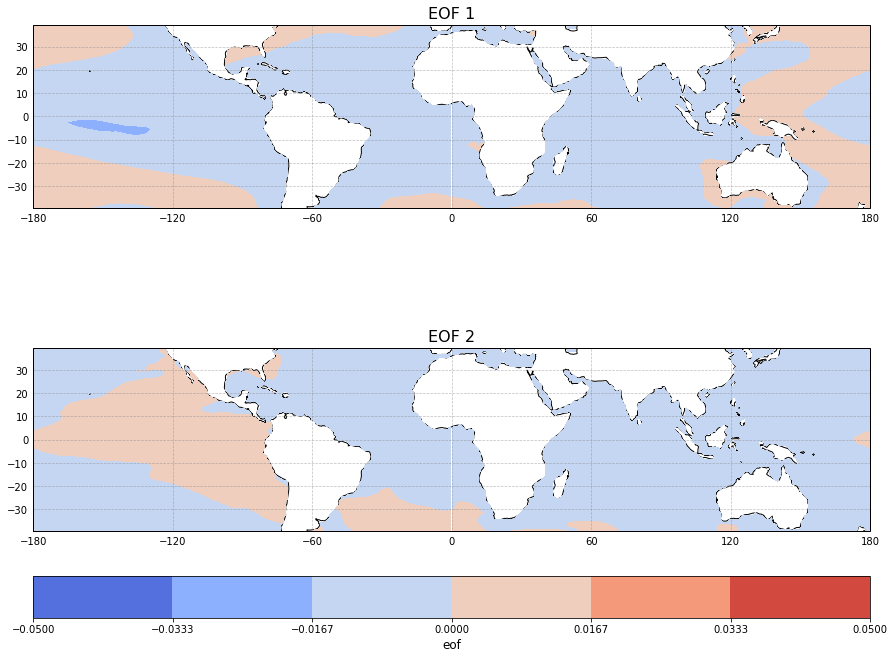

In [13]:
#################Plot the leading EOF in the Pacific domain#############################
lons,lats=np.meshgrid(lon,lat[latselect])
clevs = np.linspace(-0.05, 0.05, 7)

fig,(ax1,ax2)=plt.subplots(2,1,subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(15,12))

fill1 = ax1.contourf(lons, lats, eof[0,:,:].squeeze(), clevs,transform=ccrs.PlateCarree(), cmap='coolwarm' )
ax1.add_feature(cfeature.LAND, facecolor='w', edgecolor='k')
ax1.set_title('EOF 1', fontsize=16)
gl=ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

fill2 = ax2.contourf(lons, lats, eof[1,:,:].squeeze(), clevs,transform=ccrs.PlateCarree(), cmap='coolwarm')
ax2.add_feature(cfeature.LAND, facecolor='w', edgecolor='k')
ax2.set_title('EOF 2', fontsize=16)
gl=ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


cb = plt.colorbar(fill2, orientation='horizontal')
cb.set_label('eof', fontsize=12)

plt.savefig('eof_sst_pacific.png')